In [106]:
using RCall, DataFrames, ModelingToolkit, DifferentialEquations
figsize(;width,height) = RCall.ijulia_setdevice(MIME"image/svg+xml"(); width, height)
R"
require(tidyverse)
theme_set(theme_bw())
";

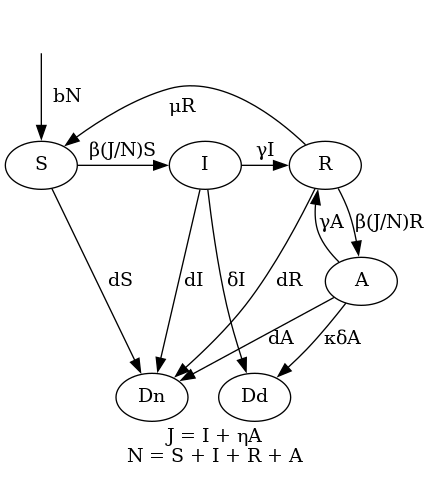

In [46]:
pipeline(`echo '
digraph {
label = <J = I + ηA<br/>N = S + I + R + A>
subgraph {
    rank = same
    S -> I [label=<β(J/N)S>]
    I -> R [label=γI]
    R -> S [label=<<br/>μR>, constraint=false]
}

subgraph {
    R -> A [label=<β(J/N)R>]
    A -> R [label=γA]
}

subgraph {
    birth [label=<>, shape=none]
    birth -> S [label=<  bN>]
    S -> Dn [label=dS]
    I -> Dn [label=dI]
    R -> Dn [label=dR]
    A -> Dn [label=dA]
    I -> Dd [label=δI]
    A -> Dd [label=κδA]
}
}
'`, `dot -Tpng`, "SIRAD.png") |> run

display("image/png", read("SIRAD.png"))

- birth rate $b$
- death rate $d$
- attack rate $\beta$
- generation interval $\displaystyle\frac{1}{\gamma}$
- infection fatality rate(IFR) $\delta$
- hazard ratio of IFR with reinfection $\kappa$

In [132]:
@parameters t b d β γ μ η δ κ
@variables S(t) I(t) R(t) A(t) D_n(t) D_d(t)
@variables J(t) N(t) I_new(t) I_re(t) d_n(t) d_d(t)

D = Differential(t)
@named sys = ODESystem([
    J ~ I+η*A,
    N ~ S+I+R+A,
    D(S) ~ + b*N + μ*R - I_new - d*S,
    D(I) ~ + I_new - γ*I - d*I - δ*I,
    D(R) ~ + γ*I + γ*A - μ*R - d*R - I_re,
    D(A) ~ + I_re - γ*A - d*A - κ*δ*A,
    D(D_d) ~ d_d,
    D(D_n) ~ d_n,
    I_new ~ β*J/N*S,
    I_re ~ β*J/N*R,
    d_d ~ + δ*I + κ*δ*A,
    d_n ~ + d*S + d*I + d*R + d*A,
])

Model sys with 12 equations
States (12):
  S(t)
  I(t)
  R(t)
  A(t)
  D_d(t)
  D_n(t)
⋮
Parameters (8):
  η
  μ
  d
  b
  γ
  δ
⋮

In [128]:
R0 = 2.5
generation_interval = 5
longevity_of_immunity = 100
prob = ODEProblem(
    structural_simplify(sys),
    [ S => 1-1e-6, I => 1e-6, R => 0, A => 0, D_d => 0, D_n => 0 ],
    (0, 365.25*3),
    [
        b => 7.8/1000/365.25,
        d => 12.7/1000/365.25,
        β => R0/generation_interval,
        γ => 1/generation_interval,
        μ => 1/longevity_of_immunity, 
        η => .5,
        δ => .5/100, 
        κ => 1/100
    ]
)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1095.75)
u0: 6-element Vector{Float64}:
 0.999999
 1.0e-6
 0.0
 0.0
 0.0
 0.0

In [170]:
?Euler

search: Euler EulerHeun PCEuler ISSEulerHeun LieEuler SplitEuler LambaEulerHeun



Euler - The canonical forward Euler method. Fixed timestep only.


In [176]:
nrow(df)

78

┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


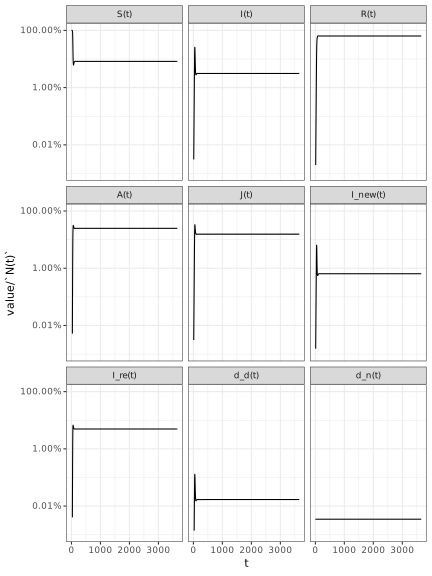

RObject{VecSxp}


In [195]:
sol = solve(
    remake(prob; 
        # p=[
        #     β => 1.3/5,
        #     γ => 1/5,
        #     η => 0,
        #     μ => 1/1000
        # ], 
        tspan=(0,365.25*10)
    ),
)

df = DataFrame(;
    t = sol[t],
    [ Symbol(s) => sol[s] for s in states(sys) ]...
)

figsize(width=6, height=8)
R"
require(scales)
df = $df %>%
    select(-c(`D_d(t)`, `D_n(t)`)) %>%
    relocate(t, `N(t)`)    
vars = colnames(df) %>% tail(-2)
df %>%    
    pivot_longer(-c(t,`N(t)`)) %>%
    ggplot() +
    facet_wrap(~ factor(name, levels=vars), ncol=3) + 
    geom_line(aes(t, value/`N(t)`)) +
    scale_y_log10(labels=percent, limit=c(1/100000, NA))
"